In [1]:
from pathlib import Path

import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
from wmfdata import charting, hive


You are using wmfdata v1.3.1, but v1.3.2 is available.

To update, run `pip install --upgrade git+https://github.com/wikimedia/wmfdata-python.git@release --ignore-installed`.

To see the changes, refer to https://github.com/wikimedia/wmfdata-python/blob/release/CHANGELOG.md


In [2]:
%matplotlib inline
charting.set_mpl_style()

In [3]:
# UPDATE FOR NEW MONTH!
# Metric month. The mediawiki_history snapshot for this month must be available.
# METRICS_MONTH_TEXT = "2019-07"
# MEDIAWIKI_HISTORY_SNAPSHOT = "2019-07"

last_month = datetime.date.today().replace(day=1) - datetime.timedelta(days=1)
first_day_month = last_month.replace(day=1)

METRICS_MONTH_TEXT = last_month.strftime("%Y-%m")
MEDIAWIKI_HISTORY_SNAPSHOT = last_month.strftime("%Y-%m")

metrics_month = pd.Period(METRICS_MONTH_TEXT)
insert_start = str(metrics_month)
insert_end = str(metrics_month + 1)
graph_start = str(metrics_month - 48)

# Update table

In [4]:
create_cmd = Path("queries/create_editor_month.sql").read_text()
update_cmd = Path("queries/update_editor_month.sql").read_text().format(
    start=insert_start,
    end=insert_end,
    mwh_snapshot=MEDIAWIKI_HISTORY_SNAPSHOT
)

In [5]:
#update data base access
os.system("hdfs dfs -chmod -R o+rw /user/hive/warehouse/neilpquinn.db/editor_month")

0

In [6]:
hive.run(create_cmd)

# check latest date before updating the table
max_month = hive.run("""
select
    max(month) as max
from neilpquinn.editor_month 
limit 1000
""")

if datetime.datetime.strptime(max_month.loc[0,max] , '%Y-%m-%d %H:%M:%S').date() < first_day_month:
    hive.run(update_cmd)

In [7]:
#update data base access
os.system("hdfs dfs -chmod -R o+r /user/hive/warehouse/neilpquinn.db/editor_month")

0

# Quality checks

In [8]:
editors = hive.run("""
select
    month,
    count(*) as editors,
    sum(cast(content_edits >= 5 as int)) as active_editors,
    sum(cast(content_edits >= 100 as int)) as very_active_editors
from neilpquinn.editor_month 
group by month
order by month asc
limit 1000
""")

editors = (
    editors
    .assign(month=lambda df: pd.to_datetime(df["month"]))
    .set_index("month")
)

editors.tail()

,editors,active_editors,very_active_editors
month,,,
2021-09-01,391096,113350,18160
2021-10-01,401505,115100,18160
2021-11-01,400464,114512,17894
2021-12-01,392317,114299,18017
2022-01-01,425378,121493,19447


In [9]:
editors_per_wiki = hive.run("""
select
    month,
    wiki,
    count(*) as editors 
from neilpquinn.editor_month 
where
    wiki in ("arwiki", "dewiki", "enwiki", "kowiki", "zhwiki")
group by month, wiki
order by month, wiki
limit 10000
""")

editors_per_wiki = (
    editors_per_wiki
    .assign(month=lambda df: pd.to_datetime(df["month"]))
    .set_index("month")
    .pivot(columns="wiki")
    .xs("editors", axis=1)
)

editors_per_wiki.tail()

wiki,arwiki,dewiki,enwiki,kowiki,zhwiki
month,,,,,
2021-09-01,5274.0,18168.0,129608.0,2188.0,8536.0
2021-10-01,6500.0,18459.0,130971.0,2246.0,8580.0
2021-11-01,8633.0,18828.0,128860.0,2298.0,8094.0
2021-12-01,7295.0,18909.0,124805.0,2299.0,8376.0
2022-01-01,5784.0,21633.0,136803.0,2256.0,8606.0


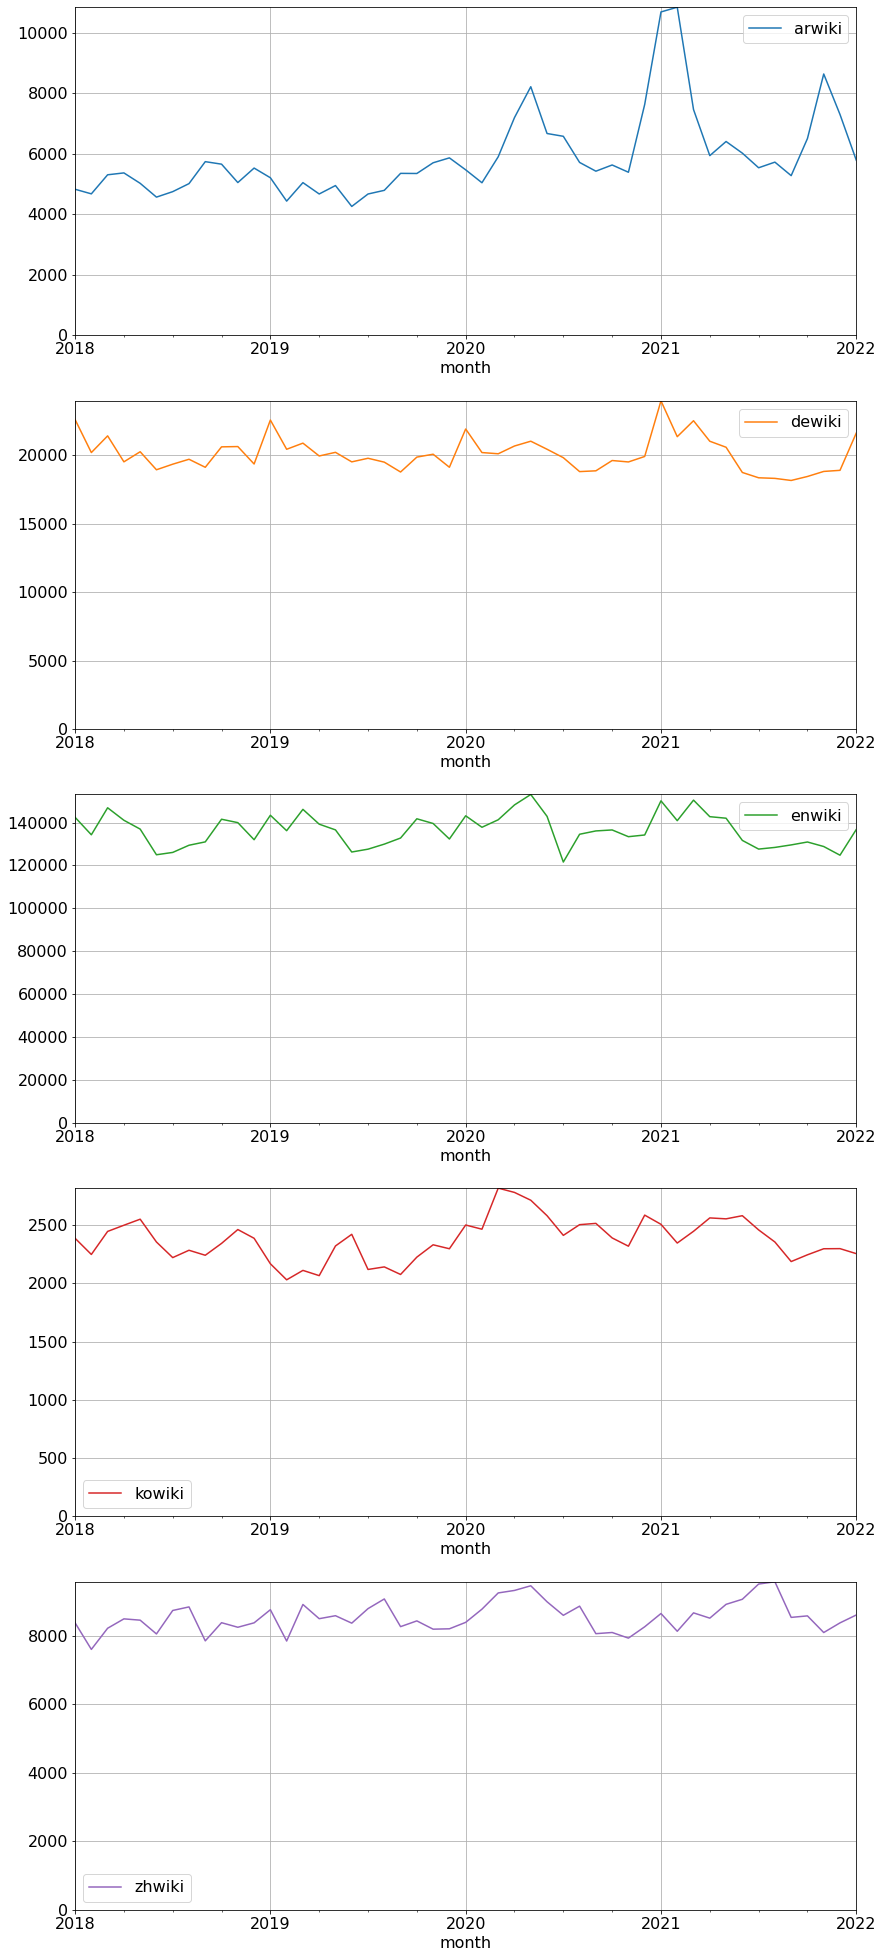

In [10]:
editors_per_wiki[graph_start:].plot(
    ylim=0,
    subplots=True,
    figsize=(14, 35),
    sharex=False
);